In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.svm as svm

### Data Modeling

#### Normalization : MinMaxScaler

In [2]:
d_final = pd.read_csv('C://workspaces//AI//Final_PJT//final pjt//d_final.csv', encoding = 'utf-8')

In [3]:
d_final.head()

,id,sex,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,...,tobacco,contact_other_covid,covid_res,icu,DEATH,d_ent,d_sym,d_last,diff_days,age_grp
0,167386,1,2,2,54,2,2,2,2,2,...,2,3,1,2,0,2020-04-06,2020-04-01,2020-06-29,89,3.0
1,0b5948,2,2,1,30,2,2,2,2,2,...,2,3,1,2,0,2020-04-17,2020-04-10,2020-06-29,80,2.0
2,0d01b5,1,2,2,60,2,1,2,2,2,...,2,3,1,2,1,2020-04-13,2020-04-13,2020-04-22,9,4.0
3,1beec8,2,2,1,47,2,1,2,2,2,...,2,3,1,1,1,2020-04-16,2020-04-16,2020-04-29,13,3.0
4,1.75E+56,2,2,2,63,2,2,2,2,2,...,2,3,1,2,0,2020-04-22,2020-04-13,2020-06-29,77,4.0


In [4]:
# 정규화할 변수만 d_normal0에 저장
d_normal0 = d_final.loc[:, ['sex', 'intubed', 'pneumonia', 'age_grp', 'pregnancy', 'diabetes', 'copd', 'asthma', 'inmsupr',
                            'hypertension', 'other_disease', 'obesity', 'cardiovascular', 'renal_chronic', 
                            'tobacco', 'contact_other_covid', 'covid_res', 'icu']]

# y(종속변수)는 정규화 하지않고 따로 저장
d_y = d_final.loc[:, ['DEATH', 'diff_days']]

In [5]:
# 정규화
d_normal = MinMaxScaler(feature_range=(0,1)).fit_transform(d_normal0)
d_normal

array([[0. , 0.5, 0.5, ..., 1. , 0. , 0.5],
       [1. , 0.5, 0. , ..., 1. , 0. , 0.5],
       [0. , 0.5, 0.5, ..., 1. , 0. , 0.5],
       ...,
       [1. , 0. , 0. , ..., 0.5, 1. , 0. ],
       [0. , 0.5, 0. , ..., 1. , 1. , 0.5],
       [0. , 0.5, 0. , ..., 1. , 1. , 0.5]])

#### Train, Test set 분리

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(d_normal, d_y, shuffle = True, test_size = 0.2, random_state = 1004)

In [7]:
print(X_train.shape[:],'\n', X_test.shape[:], '\n', Y_train.shape[:], '\n', Y_test.shape[:])  

(91046, 18) 
 (30349, 18) 
 (91046, 2) 
 (30349, 2)


#### Support Vector Machine

##### SVM Hyper Parameter Tuning

In [ ]:
# Non-linear kernel
Y_train2 = Y_train.loc[:, "diff_days"]
svm_model = svm.SVR(kernel = 'rbg', probability =True, random_state=1004)
parameters = {'C' : [0.01, 0.1, 1, 10, 25, 50, 100],
             'gamma' : [0.01, 0.1, 1, 10, 25, 50, 100]}

In [ ]:
grid_svm = GridSearchCV(svm_model, 
                       param_grid = parameters,
                       cv = KFold(3, random_state = 1004, shuffle=True),
                       n_jobs = 4)

In [ ]:
grid_svm.fit(X_train, Y_train2)

In [ ]:
# 최적 parameter 확인
print("Best parameters (5-fold CV, gird search): " , grid_svm.best_params_)
print("Best accuracy (5-fold CV, gird search): " , grid_svm.best_score_)

In [ ]:
cv_result_df = pd.DataFrame(grid_svm.cv_results_)
cv_result_df.sort_values(by=['rank_test_score'], inplace=True)

In [ ]:
cv_result_df[['params', 'mean_test_score', 'rank_test_score']].head()

In [ ]:
# 최적 parameter로 xgboost 모델 생성 및 예측
svm_best = svm_model.best_estimator_
Y_pred = svm_best.predict(X_test) ; Y_pred # 예측값

In [ ]:
svm_best

### Test set 성능 평가
- Test set에서의 결과 평가
- 개념설명은 https://bcho.tistory.com/1206 참고
- https://datascienceschool.net/view-notebook/731e0d2ef52c41c686ba53dcaf346f32/

In [79]:
Y_test2 = Y_test.loc[:, "diff_days"] # True 값
Y_test2 = Y_test2.reset_index(drop=True)

In [80]:
print('RMSE : %.3f' % np.sqrt(mean_squared_error(Y_test2, Y_pred)))

RMSE : 24.825


#### X축 : Y, Y축 : predicted Y 산점도 작성

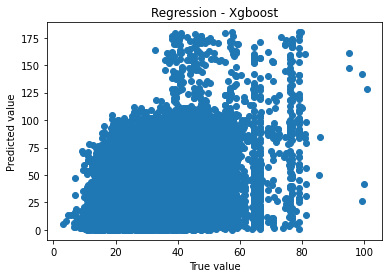

In [81]:
plt.plot(Y_pred, Y_test2, 'o')
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title('Regression - Xgboost')
plt.show()

#### Y, Predicted Y export (나중에 그래프 그릴 때 쓰게)

In [74]:
d_trueY = pd.DataFrame({'Y_pred':Y_test2}).reset_index(drop=True)
d_predY = pd.DataFrame({'Y_pred':Y_pred})

In [75]:
reg_svm = pd.concat([d_trueY, d_predY], axis = 1).reset_index(drop=True)
reg_svm

,Y_pred,Y_pred
0,18,20.315592
1,5,13.699874
2,54,32.700806
3,43,37.117157
4,50,24.958183
...,...,...
30344,98,53.785538
30345,14,12.194184
30346,71,41.374111
30347,48,27.148941


In [76]:
reg_svm.to_csv('C://workspaces//AI//Final_PJT//final pjt//reg_xgboost.csv', encoding='utf-8', index=False, line_terminator='\n')